In [2]:
import numpy as np
from tenpy.models.hubbard import BoseHubbardModel
from tenpy.networks.mps import MPS
from tenpy.algorithms import tebd

# --- Define Model Parameters ---
# L: number of sites; Nmax: maximum number of bosons per site (should be >= max occupation)
model_params = {
    'L': 2,          # Two sites
    'Nmax': 3,       # Maximum occupation per site (adjust as needed)
    't': 1.0,        # Hopping amplitude
    'U': 1.0,        # On-site interaction strength
    'mu': 0.0,       # Chemical potential
}
model = BoseHubbardModel(model_params)

# --- Prepare the Initial State ---
# Here we use the product state [1, 1], meaning 1 boson per site.
# The method lat.mps_sites() sets up the local Hilbert spaces.
initial_state = [1, 1]
psi = MPS.from_product_state(model.lat.mps_sites(), initial_state, bc="finite")

# --- TEBD Time Evolution Parameters ---
tebd_params = {
    'trunc_params': {
        'chi_max': 100,  # Maximum bond dimension
        'svd_min': 1e-10,  # SVD truncation threshold
    },
    'N_steps': 100,      # Number of time steps
    'dt': 0.05,          # Time step size
    'order': 2,          # Second order Trotter decomposition
    'verbose': True,     # Print progress
}

# Initialize the TEBD engine with the state and model
tebd_engine = tebd.TEBD(psi, model, tebd_params)

# Prepare lists to store observables during time evolution
times = []
n0_expect = []
n1_expect = []

# --- Time Evolution Loop ---
for step in range(tebd_params['N_steps']):
    tebd_engine.run_one_step()  # Evolve the state by dt
    current_time = (step + 1) * tebd_params['dt']
    times.append(current_time)
    n0_expect.append(psi.expectation_value("n", 0))  # Number operator expectation at site 0
    n1_expect.append(psi.expectation_value("n", 1))  # Number operator expectation at site 1

print("Time evolution complete.")
print("Times:", times)
print("Site 0 occupations:", n0_expect)
print("Site 1 occupations:", n1_expect)


c:\Users\naeve\anaconda3\envs\use_tenpy\Lib\site-packages\tenpy\tools\params.py:232: UserWarning: unused option ['Nmax'] for config BoseHubbardModel
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


AttributeError: module 'tenpy.algorithms.tebd' has no attribute 'TEBD'

# Tenpy is designed for larger lattices. For my requirements QuTip is supposed to work well

## Let's reproduce the results from Su's MATLAB code:

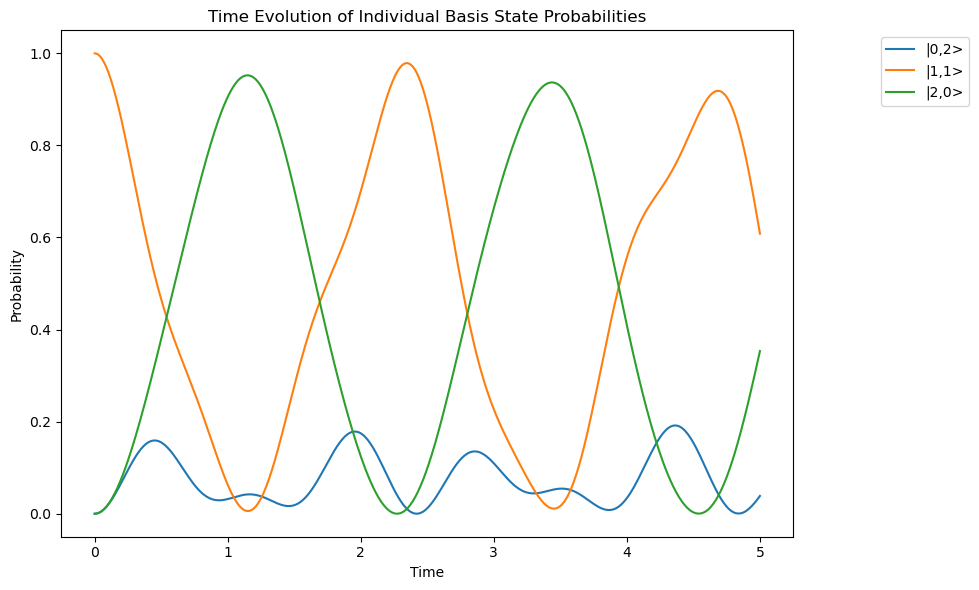

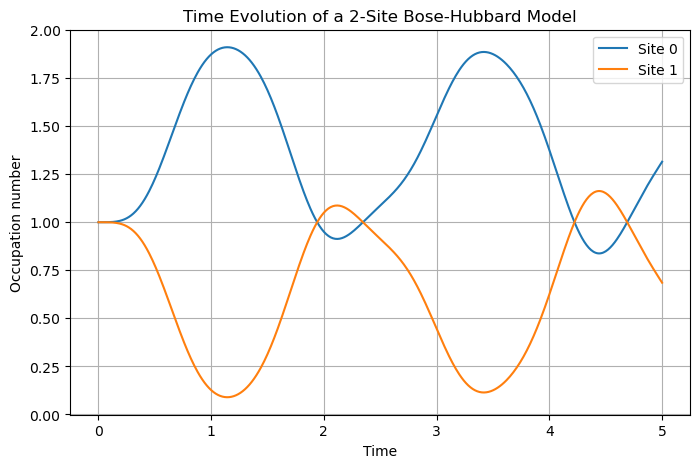

In [ ]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# --- Parameters ---
J = 1.0       # Hopping amplitude
U = 3.0       # On-site interaction strength
mu = 0.0      # Chemical potential (set to zero for simplicity)
Delta = 3.0   # energy tilt of sites
Nmax = 2      # Maximum boson number per site (Hilbert space dimension d = Nmax+1)
d = Nmax + 1

# --- Define Operators ---
# Single-site bosonic operators in the truncated Fock space
a = qt.destroy(d)
adag = a.dag()
n_op = adag * a

# --- Construct Hamiltonian ---
# Hopping term: -t (a† ⊗ a + a ⊗ a†)
H_hop = -J * (qt.tensor(adag, a) + qt.tensor(a, adag))

# Interaction term: (U/2) * [n(n-1)] on each site
# We subtract the identity appropriately to compute n(n-1)
H_int = (U/2) * (qt.tensor(n_op * (n_op - qt.qeye(d)), qt.qeye(d)) +
                 qt.tensor(qt.qeye(d), n_op * (n_op - qt.qeye(d))))

# Chemical potential term (if desired)
H_mu = - mu * (qt.tensor(n_op, qt.qeye(d)) + qt.tensor(qt.qeye(d), n_op))

#tilt potential
H_tilt = Delta * (1*qt.tensor(n_op, qt.qeye(d)) + 2*qt.tensor(qt.qeye(d), n_op))

# Total Hamiltonian
H = H_hop + H_int + H_mu + H_tilt

# --- Define Initial State ---
# The product Fock state |1,1> (one boson per site)
psi0 = qt.tensor(qt.basis(d, 1), qt.basis(d, 1))

# --- Time Evolution Setup ---
tlist = np.linspace(0, 5, 501)  # Evolve from time 0 to 5 in 101 steps

# We want to monitor the number operator expectation values at each site.
e_ops = [qt.tensor(n_op, qt.qeye(d)), qt.tensor(qt.qeye(d), n_op)]

# Create an Options object with store_states=True
opts = qt.Options(store_states=True)

# Run the evolution and store the full state history
result = qt.sesolve(H, psi0, tlist, e_ops=e_ops, options=opts)


# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]

# Plot the probability for each basis state over time
plt.figure(figsize=(10, 6))
for idx, label in enumerate(basis_labels):
    if idx==2 or idx==4 or idx==6:
        plt.plot(tlist, probs[:, idx], label=label)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Time Evolution of Individual Basis State Probabilities')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# --- Plot the Results ---
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label='Site 0')
plt.plot(tlist, result.expect[1], label='Site 1')
plt.xlabel('Time')
plt.ylabel('Occupation number')
plt.title('Time Evolution of a 2-Site Bose-Hubbard Model')
plt.legend()
plt.grid(True)
plt.show()


## If we add NNI and DIT

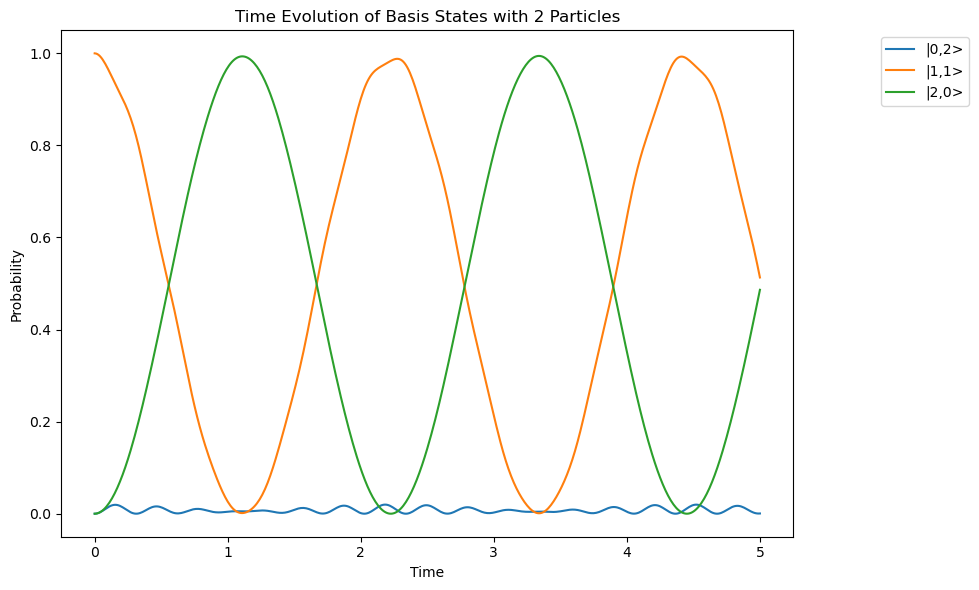

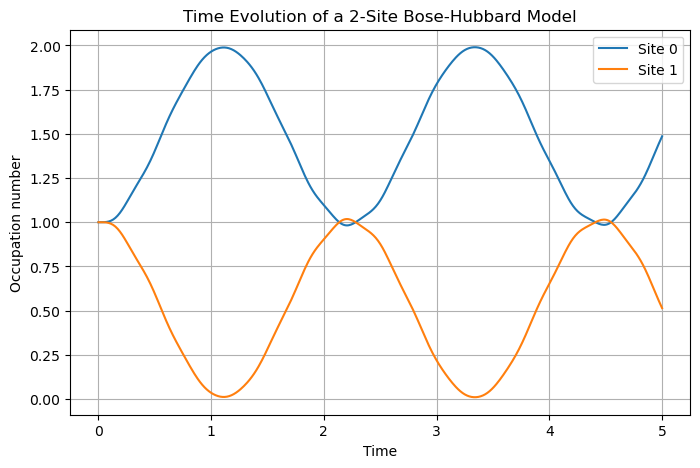

In [77]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# --- Parameters ---
J = 1.0       # Hopping amplitude
U = 10.0       # On-site interaction strength
mu = 0.0      # Chemical potential (set to zero for simplicity)
Delta = 10.0   # energy tilt of sites
V = 0.        # nearest neighbour interaction energy (due to DDI)
DeltaJ = 0.   # density induced tunneling

Nmax = 2      # Maximum boson number per site (Hilbert space dimension d = Nmax+1)
d = Nmax + 1

# --- Define Operators ---
# Single-site bosonic operators in the truncated Fock space
a = qt.destroy(d)
adag = a.dag()
n_op = adag * a

# --- Construct Hamiltonian ---
# Hopping term: -J (a† ⊗ a + a ⊗ a†)
H_hop = -J * (qt.tensor(adag, a) + qt.tensor(a, adag))

# Interaction term: (U/2) * [n(n-1)] on each site
# We subtract the identity appropriately to compute n(n-1)
H_int = (U/2) * (qt.tensor(n_op * (n_op - qt.qeye(d)), qt.qeye(d)) +
                 qt.tensor(qt.qeye(d), n_op * (n_op - qt.qeye(d))))

# Chemical potential term (if desired)
H_mu = - mu * (qt.tensor(n_op, qt.qeye(d)) + qt.tensor(qt.qeye(d), n_op))

#tilt potential
H_tilt = Delta * (1*qt.tensor(n_op, qt.qeye(d)) + 2*qt.tensor(qt.qeye(d), n_op))

#nearest neighbour interaction
H_nni = V * qt.tensor(n_op, qt.qeye(d)) * qt.tensor(qt.qeye(d), n_op)

#density induced tunneling
H_dit = - DeltaJ * (qt.tensor(adag,a)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1) +
                    qt.tensor(a,adag)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1))


# Total Hamiltonian
H = H_hop + H_int + H_mu + H_tilt + H_nni + H_dit

# --- Define Initial State ---
# The product Fock state |1,1> (one boson per site)
psi0 = qt.tensor(qt.basis(d, 1), qt.basis(d, 1))

# --- Time Evolution Setup ---
tlist = np.linspace(0, 5, 501)  # Evolve from time 0 to 5 in 101 steps

# We want to monitor the number operator expectation values at each site.
e_ops = [qt.tensor(n_op, qt.qeye(d)), qt.tensor(qt.qeye(d), n_op)]

# Create an Options object with store_states=True
opts = qt.Options(store_states=True)

# Run the evolution and store the full state history
result = qt.sesolve(H, psi0, tlist, e_ops=e_ops, options=opts)


# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == 2]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

# Plot the probability for each 2-particle basis state over time
plt.figure(figsize=(10, 6))
for idx, label in zip(indices_2particles, labels_2particles):
    plt.plot(tlist, probs[:, idx], label=label)
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Time Evolution of Basis States with 2 Particles')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# --- Plot the Results ---
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label='Site 0')
plt.plot(tlist, result.expect[1], label='Site 1')
plt.xlabel('Time')
plt.ylabel('Occupation number')
plt.title('Time Evolution of a 2-Site Bose-Hubbard Model')
plt.legend()
plt.grid(True)
plt.show()


# Make tilt time dependent:

In [324]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy import constants as const

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si

In [543]:
# --- Parameters ---
J = 2*np.pi* 262#Hz       # Hopping amplitude
U = 2*np.pi* 1000      # On-site interaction strength
mu = 0.0      # Chemical potential (set to zero for simplicity)

V = 0.        # nearest neighbour interaction energy (due to DDI)
DeltaJ = 0.   # density induced tunneling

# Parameters for the tilt
Delta_start = 2*np.pi* 0   #tilt energy at start
Delta_end = 4*U     #------"-------- end

omega_J = 2*J
tau = 10*si.ms     #time duration of simulation

N_steps = int(1e3)      #number of timesteps

In [544]:
print(J)
print(U)

print(Delta_start)
print(Delta_end)

print(tau)

1646.1945504810517
6283.185307179586
0.0
25132.741228718343
0.01


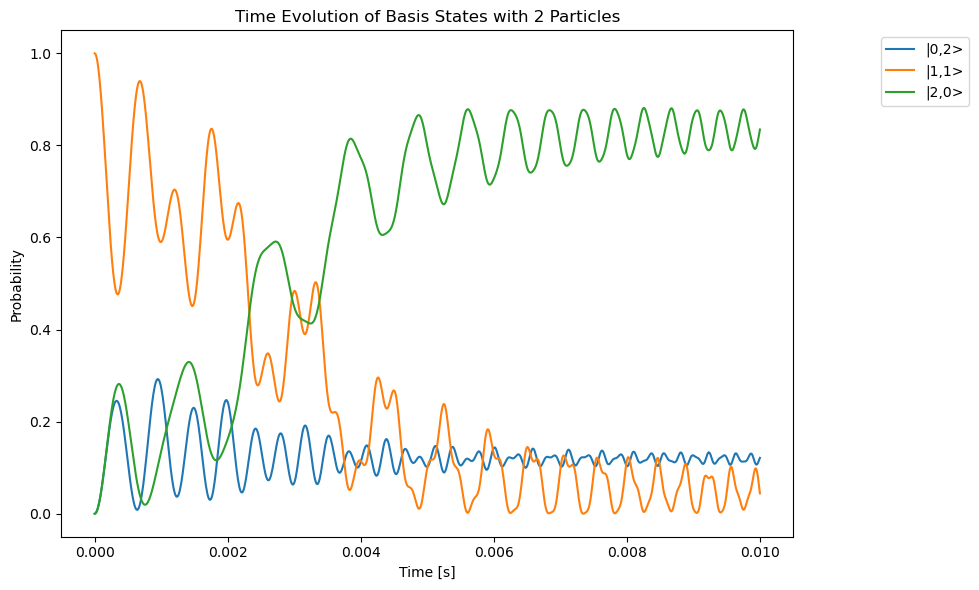

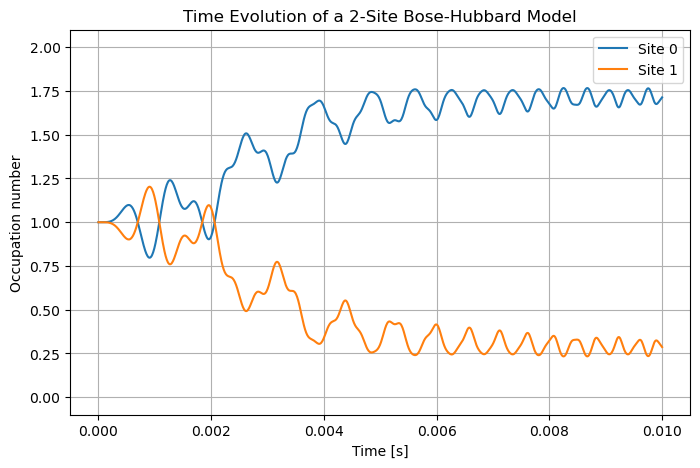

In [545]:
Nmax = 2      # Maximum boson number per site (Hilbert space dimension d = Nmax+1)
d = Nmax + 1

# --- Define Operators ---
# Single-site bosonic operators in the truncated Fock space
a = qt.destroy(d)
adag = a.dag()
n_op = adag * a

# --- Construct Hamiltonian ---
# Hopping term: -J (a† ⊗ a + a ⊗ a†)
H_hop = -J * (qt.tensor(adag, a) + qt.tensor(a, adag))
# Interaction term: (U/2) * [n(n-1)] on each site
# We subtract the identity appropriately to compute n(n-1)
H_int = (U/2) * (qt.tensor(n_op * (n_op - qt.qeye(d)), qt.qeye(d)) +
                 qt.tensor(qt.qeye(d), n_op * (n_op - qt.qeye(d))))
# Chemical potential term (if desired)
H_mu = - mu * (qt.tensor(n_op, qt.qeye(d)) + qt.tensor(qt.qeye(d), n_op))

#tilt potential
H_tilt_op = (1*qt.tensor(n_op, qt.qeye(d)) + 2*qt.tensor(qt.qeye(d), n_op))
# Define the time-dependent function for the tilt
def tilt_func(t, args):
    return args['a']+ (args['b']-args['a'])* t/args['tau']


#nearest neighbour interaction
H_nni = V * qt.tensor(n_op, qt.qeye(d)) * qt.tensor(qt.qeye(d), n_op)
#density induced tunneling
H_dit = - DeltaJ * (qt.tensor(adag,a)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1) +
                    qt.tensor(a,adag)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1))


# Total Hamiltonian
H_static = H_hop + H_int + H_mu + H_nni + H_dit

H = [H_static, [H_tilt_op, tilt_func]]
tilt_args = {'a': Delta_start, 'b': Delta_end, 'tau': tau}


# --- Define Initial State ---
# The product Fock state |1,1> (one boson per site)
psi0 = qt.tensor(qt.basis(d, 1), qt.basis(d, 1))

# --- Time Evolution Setup ---
tlist = np.linspace(0, tau, N_steps)  # Evolve from time 0 to 5 in 101 steps

# We want to monitor the number operator expectation values at each site.
e_ops = [qt.tensor(n_op, qt.qeye(d)), qt.tensor(qt.qeye(d), n_op)]

# Create an Options object with store_states=True
opts = qt.Options(store_states=True, nsteps=10000)

# Run the evolution and store the full state history
result = qt.sesolve(H, psi0, tlist, e_ops=e_ops, options=opts, args=tilt_args)


# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == 2]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

# Plot the probability for each 2-particle basis state over time
plt.figure(figsize=(10, 6))
for idx, label in zip(indices_2particles, labels_2particles):
    plt.plot(tlist, probs[:, idx], label=label)
plt.xlabel('Time [s]')
plt.ylabel('Probability')
plt.title('Time Evolution of Basis States with 2 Particles')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# --- Plot the Results ---
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label='Site 0')
plt.plot(tlist, result.expect[1], label='Site 1')
plt.ylim(-0.1,2.1)
plt.xlabel('Time [s]')
plt.ylabel('Occupation number')
plt.title('Time Evolution of a 2-Site Bose-Hubbard Model')
plt.legend()
plt.grid(True)
plt.show()


### Fidelity should be given by probability of |2,0> (if particles are perfectly indistinguishable)

In [546]:
np.mean(probs[-int(N_steps/5):,6])

0.8284621706456528